In [33]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *
from func_sel import *
import pyreadstat
import pandas as pd
from crear_dataset import *


In [34]:

df_orig, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

print("Creem diccionari")

Creem diccionari


In [35]:

df = create_dataset_2(df_orig, dict)
df = origen(df,df_orig)

Hola


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Delictes molt violents'] = 0
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[dict[num]] = np.where(df[dict[num]] == 5, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [36]:
print("Mirem quants nans tenim a cada columna")
netejat,df = neteja_na_columns(df, llindar=0.6)

df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)

df['temps_fins_reincidencia1a'] = df['temps_fins_reincidencia1a'].apply(lambda x: 1095 if x > 1095 else x)

Mirem quants nans tenim a cada columna
Columnes netejades


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_net[col].fillna(mitjana, inplace=True)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [37]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  89  columnes


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='temps_fins_reincidencia1a'), df['temps_fins_reincidencia1a'], test_size=0.2,random_state=42)


In [39]:
from sklearn.preprocessing import StandardScaler

## normalitzem les dades
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)



In [40]:
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler


# Suposem un dataset real en 'df'
# Suposant que X_train és un DataFrame i y_train és una sèrie
X_train_2 = pd.DataFrame(X_train, columns=df.drop(columns='temps_fins_reincidencia1a').columns).reset_index(drop=True)
y_train_2 = pd.Series(y_train).reset_index(drop=True)

scaler_ytrain = MinMaxScaler()
y_train_2_t = scaler_ytrain.fit_transform(y_train_2.values.reshape(-1, 1))


df_train = X_train_2.copy()
df_train['temps_fins_reincidencia1a'] = y_train_2_t


In [66]:
from sklearn.utils import resample

# Número de mostres sintètiques que vols generar (ex. 5x el dataset original)
n_samples = len(df_train) * 15

# Fer bootstrapping: mostres amb reemplaçament
df_train_bootstrap = resample(df_train, replace=True, n_samples=n_samples, random_state=42)



In [67]:
from copulas.multivariate import GaussianMultivariate


model = GaussianMultivariate()
model.fit(df_train_bootstrap)
synthetic_data = model.sample(50)

X_synthetic = synthetic_data.drop(columns='temps_fins_reincidencia1a')
y_synthetic = synthetic_data['temps_fins_reincidencia1a']



c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6720: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\jjf20\OneDrive\Docume

In [68]:
y_synthetic_reconvertit = scaler_ytrain.inverse_transform(y_synthetic.values.reshape(-1, 1))

y_synthetic_reconvertit = pd.Series(y_synthetic_reconvertit.flatten())

print(y_synthetic_reconvertit)


0      503.705390
1      590.690137
2      303.859583
3       21.630672
4      110.696286
5       31.892263
6      317.490890
7      751.735090
8        2.345851
9     1053.358013
10       7.861382
11      52.490535
12      17.650207
13       2.645089
14      37.874662
15       1.308687
16     174.157122
17      23.216680
18      71.870669
19      20.458107
20     112.693711
21     603.656352
22     117.431569
23      84.854802
24       3.996887
25       6.241273
26     208.850083
27     202.873829
28      15.444381
29     100.043723
30     281.652509
31      40.605540
32      21.723479
33     693.503425
34     412.048985
35      15.846042
36       1.199132
37      25.189027
38       3.948269
39       1.295261
40     299.629346
41       2.050852
42     373.771482
43       1.133670
44       9.902634
45       4.103227
46      50.649868
47     107.428469
48       1.124734
49       2.330619
dtype: float64


In [69]:
import pandas as pd

# Assegura que y_train_2 és una Series
X_synthetic = pd.concat([X_train_2, X_synthetic], ignore_index=True)
y_synthetic = pd.concat([y_train_2, y_synthetic_reconvertit], ignore_index=True)


In [76]:
X_train_filtrat, coef_significatius = filter_significant_features(X_synthetic,y_synthetic, df, llindar=0.11,alpha=1, print_results=True)

Hem fet el model Lasso
Hem trobat  23  coeficients nuls
Hem trobat  65  coeficients no nuls
Els coeficients no nuls són:
EdatAD                          117.808257
Niv_Esc                         -25.040975
NSancMGreu                        0.424187
Total_Del                       -89.840250
Pri_Exp                         -48.087308
                                   ...    
Nord_America                     74.159980
Pares_Catalans                  -77.118084
Pare_Catala_Fora_Espanya         42.300433
Pares_No_Catalans_Espanya       -20.222980
Pares_No_Catalans_Un_Espanya     64.419279
Length: 65, dtype: float64
Els coeficients nuls són:
NSancLleu                     0.0
NSancGreu                    -0.0
PCLe_PT                      -0.0
PCLYVMPT                      0.0
CAPEo_PT                     -0.0
SAVRYTot                      0.0
YPI_LY                        0.0
YPI_RE                       -0.0
YPI_UN                        0.0
YPI_PT                       -0.0
YPI_II       

c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e+03, tolerance: 7.797e+02
  model = cd_fast.enet_coordinate_descent(


In [71]:
print("Les columnes més significatives són: ")
print(df.columns[coef_significatius.argsort()[::-1][0:20]])

Les columnes més significatives són: 
Index(['YPI_GR', 'EdatAD', 'SAVRYSoc', 'YPI_TS', 'PCLj_PT', 'TriPMBold',
       'TriPMMean', 't_internamentCape', 'Total_Del', 'Pri_Exp', 'YPI_UN',
       'Ant_Jo', 'YPI_PT', 'CAPEo_PT', 'PCLx_PT', 'temps_fins_reincidencia1a',
       'TRFTTotProb', 'VASTTotal', 'ICUJ_PT', 'TRFMGrupExtCAPEe'],
      dtype='object')


In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## fem grid search per trobar els millors hiperparàmetres

param_grid = {
    'n_estimators': [20,50,100],
    'max_depth': [300,400,500],
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_filtrat, y_synthetic)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

# Mostrem la mitjana dels resultats de test
print("Mitjana dels resultats de test per cada combinació:")
print(np.mean(grid_search.cv_results_['mean_test_score'] * -1))  # Multipliquem per -1 per obtenir el MSE positiu

best_model = grid_search.best_estimator_


Millor paràmetre: {'max_depth': 500, 'n_estimators': 20}
Millor precisió: 66413.62894513801
Mitjana dels resultats de test per cada combinació:
73244.29082287445


In [73]:
# Obtenim la importància de cada característica
coef_importants = best_model.feature_importances_

# Obtenim els noms de les característiques (suposant que tenim un DataFrame 'df')
feature_names = X_train_filtrat.columns  

# Ordenem les característiques segons la seva importància (de major a menor)
indices_ordenats = coef_importants.argsort()[::-1][0:20]

# Mostrem els noms de les 20 característiques més importants amb la seva importància
print("Les 20 característiques més importants són:")
for i in indices_ordenats:
    print(f"{feature_names[i]}: {coef_importants[i]:.4f}")



Les 20 característiques més importants són:
t_internamentCape: 0.1362
Total_Del: 0.1215
Fet10_tipologia_JA: 0.0765
TriPMDisi: 0.0720
Ant_Jo: 0.0445
CAPEe_PT: 0.0436
YSRTotProb: 0.0363
SAVRYInd: 0.0343
EdatAD: 0.0332
ICUJ_PT: 0.0255
YPI_IR: 0.0250
ICUJ_UC: 0.0236
VASTVic: 0.0212
SD3Mach: 0.0209
TRFTTotProb: 0.0195
YPI_GM: 0.0194
Eslaus: 0.0180
CAPEo2_PT: 0.0164
YPI_DC: 0.0153
SAVRYSoc: 0.0116



--- AVALUACIÓ FINAL EN TEST ---
MSE (Test): 288556.7318


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


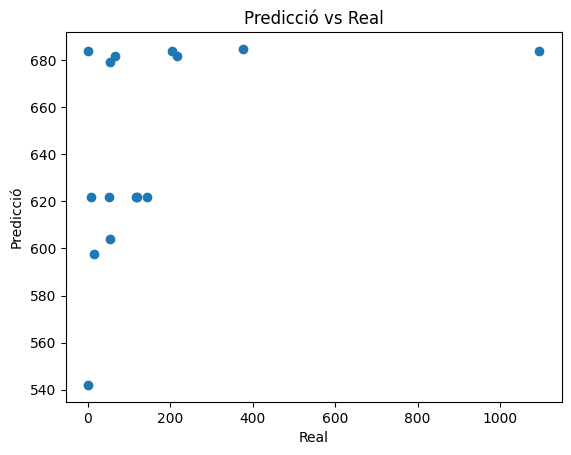

In [74]:
from sklearn.metrics import mean_squared_error, r2_score

X_test = scaler.transform(X_test)
X_test_filtrat = pd.DataFrame(X_test, columns=df.drop(columns='temps_fins_reincidencia1a').columns)[coef_significatius.index]


y_test_pred = best_model.predict(X_test_filtrat)

# Calculem la mètrica MSE i R²
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- AVALUACIÓ FINAL EN TEST ---")
print(f"MSE (Test): {test_mse:.4f}")


## plot de les prediccions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.title('Predicció vs Real')
plt.show()

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## fem grid search per trobar els millors hiperparàmetres

param_grid = {
    'n_estimators': [20,50,100],
    'max_depth': [300,400,500],
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_filtrat, y_train)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

# Mostrem la mitjana dels resultats de test
print("Mitjana dels resultats de test per cada combinació:")
print(np.mean(grid_search.cv_results_['mean_test_score'] * -1))  # Multipliquem per -1 per obtenir el MSE positiu

best_model = grid_search.best_estimator_


ValueError: Found input variables with inconsistent numbers of samples: [107, 57]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

X_test = scaler.transform(X_test)
X_test_filtrat = pd.DataFrame(X_test, columns=df.drop(columns='temps_fins_reincidencia1a').columns)[coef_significatius.index]


y_test_pred = best_model.predict(X_test_filtrat)

# Calculem la mètrica MSE i R²
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- AVALUACIÓ FINAL EN TEST ---")
print(f"MSE (Test): {test_mse:.4f}")


## plot de les prediccions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.title('Predicció vs Real')
plt.show()

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definim la graella d'hiperparàmetres
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(
    xgb, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_filtrat, y_train)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

#
